# SKIN CANCER MNIST: HAM10000 CLASSIFICATION USING K-MEANS


## Assignment 1 - Data Exploration and Cleaning

### Dataset

Dataset consists of 10,015 images of skin lesions.  It is known as Human Against Machine with 10000 training images (HAM10000).  It was obtained from Kaggle, however the original dataset can be downloaded from here:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

The HAM10000 dataset served as the training set for the ISIC 2018 challenge.  It is a well known dataset for training machine learning classification models.  

Dataset consists of 3 files as follows: <br>
HAM10000_images_part1.zip (5000 JPEG files) <br>
HAM10000_images_part2.zip (5015 JPEG files) <br>
HAM10000_images_metadata.csv

there are also several supplementary files which are flattened image files: <br>
hmnist_28_28_L.csv <br>
hmnist_28_28_RGB.csv <br>
hmnist_8_8_L.csv <br>
hmnist_8_8_RGB.csv <br>

The metadata file provides: <br>
lesion_id - there are a total of 7470 unique lesions<br>
image_id - there are a total of 10,015 unique images <br>
dx - Diagnosis - there are 7 classes of skin lesions (ground truth) in the dataset: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). <br>
dx_type - histopathology (histo), follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal) <br>
age - numerical range from 0-85 </br>
sex - categorical variable male/female/other <br>
localization - categorical variable describing part of the body where lesion was located


### Initial Data Exploration

Lets do some preliminary exploration of the data.  Below, we first imported various Python libraries that would allow us to transform the data and get some basic statistics.  Then we mported one of the flattened files just to look at the data.  We displayed only the first 5 rows of the dataframe.  We note that the last column provides the label - ground truth.

In [133]:
#Libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import statistics
import glob
import cv2
import csv
import math
import os
import string
from skimage.color import rgb2gray
from PIL import Image
from skimage.feature import greycomatrix, greycoprops



#import dataset - flattened 28 x 28 grayscale images
df=pd.read_csv('hmnist_28_28_L.csv')
df.head(5)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


In [84]:
#group by lable column to determine how many images are there for each diagnosis
df.groupby('label').count()


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0774,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783
label,,,,,,,,,,,,,,,,,,,,,
0,327,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,327,327,327
1,514,514,514,514,514,514,514,514,514,514,...,514,514,514,514,514,514,514,514,514,514
2,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,...,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099
3,115,115,115,115,115,115,115,115,115,115,...,115,115,115,115,115,115,115,115,115,115
4,6705,6705,6705,6705,6705,6705,6705,6705,6705,6705,...,6705,6705,6705,6705,6705,6705,6705,6705,6705,6705
5,142,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
6,1113,1113,1113,1113,1113,1113,1113,1113,1113,1113,...,1113,1113,1113,1113,1113,1113,1113,1113,1113,1113


As we can see from the above, the dataset is not very balanced, the number of images varies greatly between different categories of diagnosis.  It was therefore decided to drop the under-respresented types of lesions and only focus on 4 categories - 2 malignant and 2 benign. Below, we split the data based on the diagnosis into separate dataframes.

In [2]:
#split dataset into 4 different dataframes based on the diagnosis
df_carcinoma=df[df['label']==1]
df_bkl=df[df['label']==2]
df_mn=df[df['label']==4]
df_melanoma=df[df['label']==6]

## Basal Cell Carcinoma

In [3]:
# Basic Statistics 
df_carcinoma.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,...,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.0
mean,142.474708,151.447471,159.025292,163.750973,166.478599,169.208171,171.628405,173.856031,174.651751,175.268482,...,170.772374,169.132296,166.912451,164.272374,161.077821,156.429961,149.571984,140.449416,131.920233,1.0
std,49.722116,42.059854,35.281676,30.729916,27.837396,25.152429,23.285332,22.207481,20.959381,20.898667,...,24.884386,25.004054,25.544482,27.294219,30.076863,35.087248,41.748617,49.073625,55.320645,0.0
min,0.000000,0.000000,2.000000,6.000000,12.000000,46.000000,80.000000,81.000000,97.000000,95.000000,...,12.000000,19.000000,51.000000,40.000000,24.000000,20.000000,6.000000,2.000000,0.000000,1.0
25%,124.000000,135.000000,145.000000,149.000000,152.000000,155.250000,158.250000,161.000000,163.000000,162.250000,...,157.000000,155.250000,154.000000,147.000000,146.000000,142.000000,134.250000,124.250000,113.000000,1.0
50%,157.000000,161.000000,165.000000,168.000000,171.000000,173.000000,174.000000,175.000000,176.000000,176.000000,...,173.000000,172.000000,171.000000,169.000000,166.000000,164.000000,159.000000,152.500000,148.000000,1.0
75%,176.000000,179.000000,182.000000,183.000000,185.000000,187.000000,187.000000,189.000000,189.000000,190.000000,...,187.750000,185.750000,183.000000,182.000000,181.000000,179.000000,176.750000,173.000000,170.000000,1.0
max,233.000000,230.000000,232.000000,232.000000,230.000000,233.000000,234.000000,234.000000,232.000000,235.000000,...,232.000000,227.000000,224.000000,228.000000,224.000000,222.000000,227.000000,223.000000,219.000000,1.0


In [4]:
#pick up the means for each pixel
av_carc=df_carcinoma.mean(axis=0)
av_carc

pixel0000    142.474708
pixel0001    151.447471
pixel0002    159.025292
pixel0003    163.750973
pixel0004    166.478599
                ...    
pixel0780    156.429961
pixel0781    149.571984
pixel0782    140.449416
pixel0783    131.920233
label          1.000000
Length: 785, dtype: float64

In [5]:
#get rid of the label column
pixels_carc=av_carc[0:784]
pixels_carc

pixel0000    142.474708
pixel0001    151.447471
pixel0002    159.025292
pixel0003    163.750973
pixel0004    166.478599
                ...    
pixel0779    161.077821
pixel0780    156.429961
pixel0781    149.571984
pixel0782    140.449416
pixel0783    131.920233
Length: 784, dtype: float64

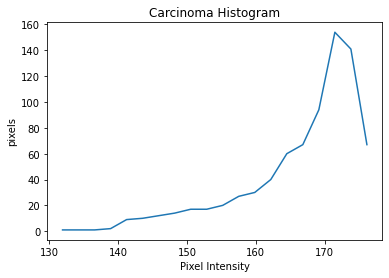

In [6]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_carc,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Carcinoma Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [89]:
#Find kurtosis of the histogram
kurt_carc = kurtosis(pixels_carc, fisher=False)
kurt_carc

4.396915883806542

In [90]:
#Find Skewness of the histogram
skew_carc = skew(pixels_carc)
skew_carc

-1.3618534010013699

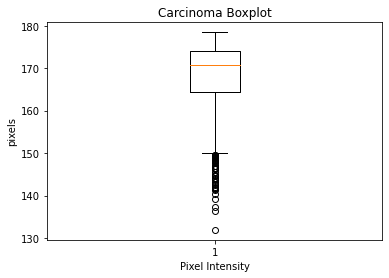

In [9]:
#Create a box plot
plt.boxplot(pixels_carc)
plt.title("Carcinoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [91]:
# Computing First and Third Quartile
Q1_carc = pixels_carc.quantile(0.25)
Q3_carc = pixels_carc.quantile(0.75)

Q1_carc,Q3_carc

(164.33171206225683, 174.02772373540856)

In [92]:
#Computing mean
mean_carc = statistics.mean(pixels_carc)
mean_carc

167.8610413523386

In [93]:
#Computing standard deviation
sd_carc = statistics.stdev(pixels_carc)
sd_carc

8.622548096732332

## Benign Keratosis

In [13]:
# Basic Statistics
df_bkl.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,...,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.0
mean,127.044586,134.572338,141.916288,147.786169,152.607825,156.636033,159.797088,161.817106,163.469518,164.577798,...,158.586897,156.734304,154.548681,151.876251,148.361237,142.708826,135.993631,127.997270,119.348499,2.0
std,54.782205,50.850123,45.634130,40.792008,36.512492,32.389766,29.178050,27.337036,26.428198,25.544313,...,27.192601,28.693824,30.551789,32.392138,35.208999,39.934085,45.822586,51.049576,55.343155,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,6.000000,8.000000,...,21.000000,24.000000,0.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,103.000000,115.000000,124.000000,131.000000,136.000000,139.000000,143.000000,145.000000,147.000000,148.000000,...,141.000000,139.000000,137.000000,134.000000,130.000000,123.000000,115.500000,104.000000,92.000000,2.0
50%,139.000000,144.000000,149.000000,153.000000,156.000000,158.000000,161.000000,162.000000,164.000000,165.000000,...,158.000000,157.000000,156.000000,154.000000,151.000000,147.000000,144.000000,139.000000,132.000000,2.0
75%,166.000000,170.000000,172.000000,174.500000,176.000000,177.000000,178.000000,179.000000,179.500000,180.000000,...,177.000000,176.000000,175.000000,173.000000,172.000000,170.000000,167.000000,163.000000,160.000000,2.0
max,238.000000,238.000000,235.000000,235.000000,234.000000,239.000000,239.000000,240.000000,238.000000,237.000000,...,244.000000,245.000000,244.000000,242.000000,249.000000,247.000000,244.000000,243.000000,240.000000,2.0


In [14]:
#pick up the means for each pixel
av_bkl=df_bkl.mean(axis=0)
av_bkl

pixel0000    127.044586
pixel0001    134.572338
pixel0002    141.916288
pixel0003    147.786169
pixel0004    152.607825
                ...    
pixel0780    142.708826
pixel0781    135.993631
pixel0782    127.997270
pixel0783    119.348499
label          2.000000
Length: 785, dtype: float64

In [15]:
#get rid of the label column
pixels_bkl=av_bkl[0:784]
pixels_bkl

pixel0000    127.044586
pixel0001    134.572338
pixel0002    141.916288
pixel0003    147.786169
pixel0004    152.607825
                ...    
pixel0779    148.361237
pixel0780    142.708826
pixel0781    135.993631
pixel0782    127.997270
pixel0783    119.348499
Length: 784, dtype: float64

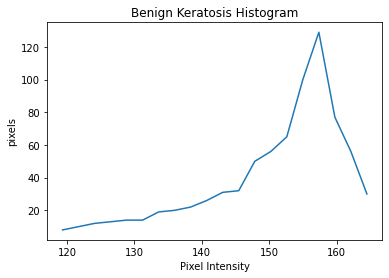

In [16]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_bkl,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Benign Keratosis Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [121]:
#Find kurtosis of the histogram
kurt_bkl = kurtosis(pixels_bkl, fisher=False)
kurt_bkl

3.405378041175825

In [122]:
#Find Skewness of the histogram
skew_bkl = skew(pixels_bkl)
skew_bkl

-1.075407049741422

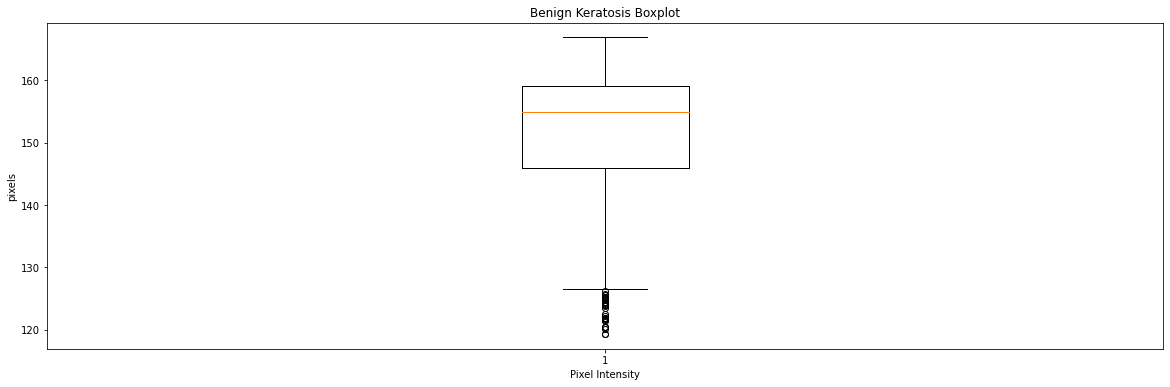

In [123]:
#Create a box plot
plt.boxplot(pixels_bkl)
plt.title("Benign Keratosis Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [118]:
# Computing 1st and 3rd Quartile
Q1_bkl = pixels_bkl.quantile(0.25)
Q3_bkl = pixels_bkl.quantile(0.75)

Q1_bkl,Q3_bkl


(146.00295723384897, 159.01205641492265)

In [117]:
#Computing mean
mean_bkl = statistics.mean(pixels_bkl)
mean_bkl

151.44817412861414

In [119]:
#Computing SD
sd_bkl = statistics.stdev(pixels_bkl)
sd_bkl

10.74575037284487

## Melanocytic Nevi

In [23]:
df_mn.info()  #we have 6705 rows whereas for other classes we have much less

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6705 entries, 64 to 9686
Columns: 785 entries, pixel0000 to label
dtypes: int64(785)
memory usage: 40.2 MB


From the info about the dataset we can see that for this class of diagnosis, there are 6,705 images which is much more than any other class.  Therefore, we decided to randomly sample 1,100 images from this class so that the number of datapoints is closer to the datasets for the other diagnoses

In [94]:
#randomly select 1100 datapoints and look at descriptive statistics

df_mn_red = df_mn.sample(n=1100,random_state=142)
df_mn_red.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.0
mean,153.315455,157.754545,160.963636,162.944545,165.556364,167.684545,169.254545,170.646364,171.364545,171.898182,...,167.390909,166.590909,166.112727,165.333636,163.041818,159.655455,156.258182,152.769091,149.087273,4.0
std,43.830818,39.894580,36.403318,34.238573,31.413812,27.560662,24.815804,23.462696,23.234235,22.903099,...,22.927665,23.071237,23.272528,24.302210,26.689740,32.608249,37.620884,41.554894,43.506932,0.0
min,0.000000,0.000000,0.000000,0.000000,5.000000,7.000000,52.000000,51.000000,43.000000,74.000000,...,5.000000,9.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
25%,145.000000,149.000000,151.000000,153.000000,154.000000,156.000000,156.000000,158.000000,158.000000,159.000000,...,153.000000,153.000000,152.000000,151.000000,149.000000,147.000000,145.000000,143.000000,139.750000,4.0
50%,164.000000,167.000000,168.000000,169.000000,170.000000,171.000000,171.000000,172.000000,172.000000,173.000000,...,168.000000,167.000000,168.000000,167.000000,166.000000,165.000000,163.500000,162.000000,159.000000,4.0
75%,179.000000,180.000000,182.000000,182.000000,183.250000,184.000000,185.000000,185.000000,186.000000,187.000000,...,182.000000,182.000000,181.000000,181.000000,180.000000,178.250000,177.000000,176.000000,174.000000,4.0
max,233.000000,234.000000,236.000000,234.000000,237.000000,238.000000,241.000000,242.000000,243.000000,247.000000,...,236.000000,234.000000,235.000000,232.000000,234.000000,234.000000,232.000000,232.000000,237.000000,4.0


We first performed the same procedures as for Basal Cell and Benign Keratosis above on the full dataset for Melanocytic Nevi. Then we reperformed them on the sampled dataframe. We wanted to see if sampling would significantly distort the statistics we are getting.

### On full dataset for mn - 6705 rows

In [25]:
#pick up the means for each pixel
av_mn=df_mn.mean(axis=0)
av_mn

pixel0000    154.427890
pixel0001    158.798359
pixel0002    162.214914
pixel0003    164.558688
pixel0004    166.907233
                ...    
pixel0780    160.433855
pixel0781    156.984191
pixel0782    153.074720
pixel0783    149.043997
label          4.000000
Length: 785, dtype: float64

In [26]:
#get rid of the label column
pixels_mn=av_mn[0:784]
pixels_mn

pixel0000    154.427890
pixel0001    158.798359
pixel0002    162.214914
pixel0003    164.558688
pixel0004    166.907233
                ...    
pixel0779    163.432215
pixel0780    160.433855
pixel0781    156.984191
pixel0782    153.074720
pixel0783    149.043997
Length: 784, dtype: float64

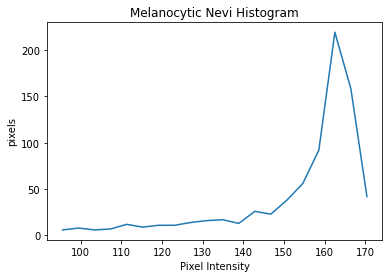

In [27]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_mn,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Melanocytic Nevi Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [95]:
#Find kurtosis of the histogram
kurt_mn = kurtosis(pixels_mn, fisher=False)
kurt_mn

5.397026066934137

In [96]:
#Find Skewness of the histogram
skew_mn = skew(pixels_mn)
skew_mn

-1.7553433356402082

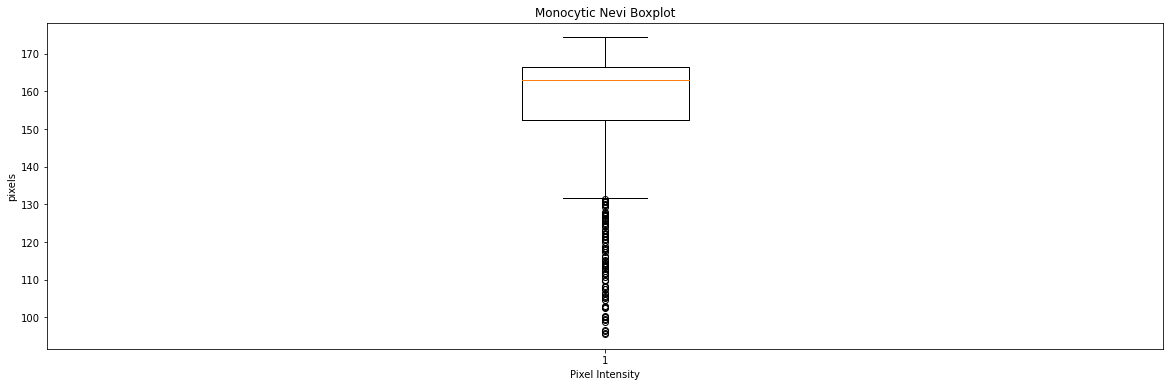

In [97]:
#Create a box plot
plt.boxplot(pixels_mn)
plt.title("Monocytic Nevi Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [98]:
# Computing 1st and 3rd Quartile
Q1_mn = pixels_mn.quantile(0.25)
Q3_mn = pixels_mn.quantile(0.75)

Q1_mn,Q3_mn


(152.4772557792692, 166.5193139448173)

### On Reduced Number of Rows - randomly sampled 1,100 images

In [32]:
#pick up the means for each pixel
av_mn_red=df_mn_red.mean(axis=0)
av_mn_red

pixel0000    152.257
pixel0001    156.832
pixel0002    160.207
pixel0003    162.303
pixel0004    164.838
              ...   
pixel0780    158.976
pixel0781    155.491
pixel0782    151.793
pixel0783    148.111
label          4.000
Length: 785, dtype: float64

In [33]:
#get rid of the label column
pixels_mn_red=av_mn_red[0:784]
pixels_mn_red

pixel0000    152.257
pixel0001    156.832
pixel0002    160.207
pixel0003    162.303
pixel0004    164.838
              ...   
pixel0779    162.488
pixel0780    158.976
pixel0781    155.491
pixel0782    151.793
pixel0783    148.111
Length: 784, dtype: float64

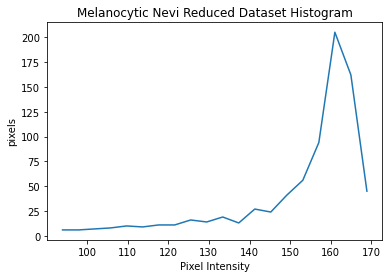

In [34]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_mn_red,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Melanocytic Nevi Reduced Dataset Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [99]:
#Find kurtosis of the histogram
kurt_mn_red = kurtosis(pixels_mn_red, fisher=False)
kurt_mn_red

5.353807204453152

In [100]:
#Find Skewness of the histogram
skew_mn_red = skew(pixels_mn_red)
skew_mn_red

-1.7341806731514338

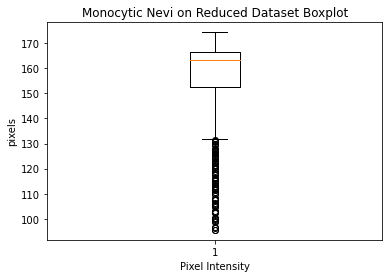

In [37]:
#Create a box plot
plt.boxplot(pixels_mn)
plt.title("Monocytic Nevi on Reduced Dataset Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [101]:
# Computing 1st and 3rd Quartile
Q1_mn_red = pixels_mn_red.quantile(0.25)
Q3_mn_red = pixels_mn_red.quantile(0.75)

Q1_mn_red,Q3_mn_red


(151.13675, 165.10825)

In [102]:
#Computing mean
mean_mn_red = statistics.mean(pixels_mn_red)
mean_mn_red

154.6677193877551

In [103]:
#Computing Standard Deviation
sd_mn_red = statistics.stdev(pixels_mn_red)
sd_mn_red

16.60872251734207

## Melanoma



In [41]:
# Get descriptive statistsics on melanoma dataset

df_melanoma.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
count,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,...,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.0
mean,124.917341,134.283917,143.216532,149.942498,155.674753,160.734052,164.639712,167.229111,168.595687,169.725966,...,166.713387,165.237197,163.253369,160.430368,156.126685,149.589398,141.782570,132.428571,122.437556,6.0
std,61.334459,56.969908,51.043736,45.695724,40.033015,34.285608,30.644435,29.110040,28.467482,27.819101,...,27.768888,28.256873,29.385532,30.864796,34.597157,41.859878,49.161342,56.031294,61.502924,0.0
min,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,25.000000,29.000000,33.000000,26.000000,...,4.000000,4.000000,5.000000,3.000000,4.000000,0.000000,1.000000,0.000000,0.000000,6.0
25%,99.000000,115.000000,125.000000,134.000000,141.000000,144.000000,147.000000,148.000000,151.000000,153.000000,...,149.000000,148.000000,145.000000,142.000000,138.000000,132.000000,124.000000,112.000000,91.000000,6.0
50%,141.000000,148.000000,153.000000,156.000000,160.000000,163.000000,166.000000,168.000000,170.000000,170.000000,...,166.000000,165.000000,164.000000,162.000000,158.000000,154.000000,150.000000,145.000000,139.000000,6.0
75%,170.000000,174.000000,178.000000,179.000000,181.000000,182.000000,185.000000,186.000000,186.000000,186.000000,...,184.000000,183.000000,182.000000,181.000000,179.000000,177.000000,175.000000,172.000000,169.000000,6.0
max,245.000000,245.000000,246.000000,250.000000,247.000000,249.000000,247.000000,249.000000,254.000000,252.000000,...,254.000000,254.000000,252.000000,251.000000,253.000000,245.000000,243.000000,235.000000,234.000000,6.0


In [42]:
#pick up the means for each pixel
av_melanoma=df_melanoma.mean(axis=0)
av_melanoma

pixel0000    124.917341
pixel0001    134.283917
pixel0002    143.216532
pixel0003    149.942498
pixel0004    155.674753
                ...    
pixel0780    149.589398
pixel0781    141.782570
pixel0782    132.428571
pixel0783    122.437556
label          6.000000
Length: 785, dtype: float64

In [43]:
#get rid of the label column
pixels_melanoma=av_melanoma[0:784]
pixels_melanoma

pixel0000    124.917341
pixel0001    134.283917
pixel0002    143.216532
pixel0003    149.942498
pixel0004    155.674753
                ...    
pixel0779    156.126685
pixel0780    149.589398
pixel0781    141.782570
pixel0782    132.428571
pixel0783    122.437556
Length: 784, dtype: float64

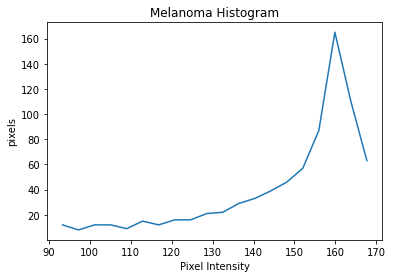

In [44]:
# Histogram of mean values of each pixel
histogram, bin_edges= np.histogram(pixels_melanoma,bins=20)
plt.plot(bin_edges[0:-1],histogram)
plt.title("Melanoma Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [104]:
#Find kurtosis of the histogram
kurt_mel = kurtosis(pixels_melanoma, fisher=False)
kurt_mel

3.869226216731156

In [105]:
#Find Skewness of the histogram
skew_mel = skew(pixels_melanoma)
skew_mel

-1.3087868472906514

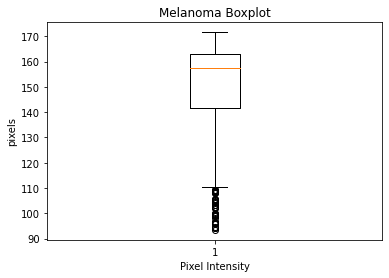

In [47]:
#Create a box plot
plt.boxplot(pixels_melanoma)
plt.title("Melanoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")
plt.show()

In [106]:
# Computing 1st and 3rd Quartile
Q1_mel = pixels_melanoma.quantile(0.25)
Q3_mel = pixels_melanoma.quantile(0.75)

Q1_mel,Q3_mel


(141.76212938005392, 163.15790655884996)

In [107]:
#Computing mean
mean_mel = statistics.mean(pixels_melanoma)
mean_mel

150.20319232814418

In [108]:
#Computing SD

sd_mel = statistics.stdev(pixels_melanoma)
sd_mel

18.510582133315243

## SUMMARY OF FIRST ORDER STATISTICS
Lets now summarize all of this by putting boxplots for all 4 classes of diagnosis side by side so we can visualize means and create a table for all the statistsics we calculated:

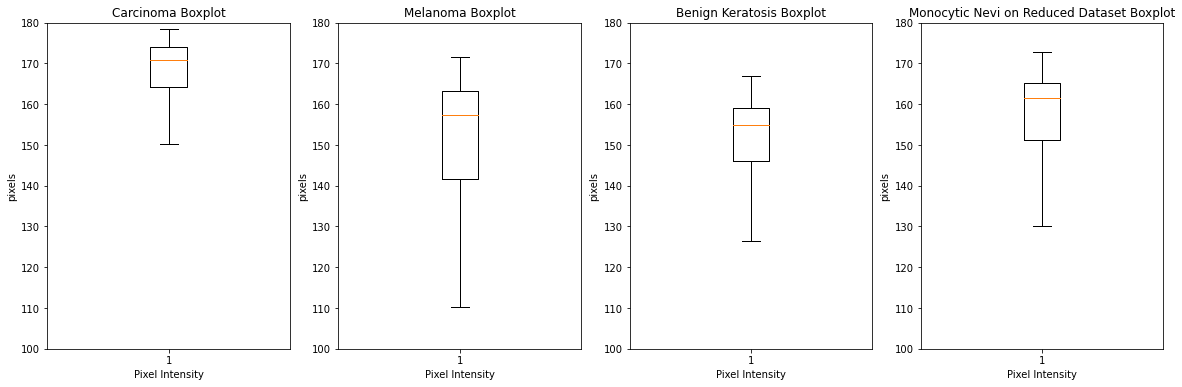

In [51]:
#Put all boxplots dide by side and on the same Y axis scale

plt.rcParams["figure.figsize"] = (20,6)


plt.subplot(1, 4, 1) # row , col 2 index 1
plt.boxplot(pixels_carc, showfliers=False)
plt.ylim([100, 180])
plt.title("Carcinoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")


plt.subplot(1, 4, 2) # index 2
plt.boxplot(pixels_melanoma, showfliers=False)
plt.ylim([100, 180])
plt.title("Melanoma Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")

plt.subplot(1, 4, 3) # index 3
plt.boxplot(pixels_bkl, showfliers=False)
plt.ylim([100, 180])
plt.title("Benign Keratosis Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")

plt.subplot(1, 4, 4) # index 4
plt.boxplot(pixels_mn_red, showfliers=False)
plt.ylim([100, 180])
plt.title("Monocytic Nevi on Reduced Dataset Boxplot")
plt.xlabel('Pixel Intensity')
plt.ylabel("pixels")

plt.show()

In [129]:
from tabulate import tabulate

first_stats = pd.DataFrame({'parameters' : ['Mean', 'Standard Deviation','Q1', 'Q3','Kurtosis', 'Skewness'],
                            'Basal Cell Carcinoma' : [mean_carc, sd_carc, Q1_carc, Q3_carc, kurt_carc, skew_carc],
                            'Benign Keratosis': [mean_bkl, sd_bkl, Q1_bkl, Q3_bkl, kurt_bkl, skew_bkl],
                            'Melanocytic Nevi - Sample': [mean_mn_red, sd_mn_red,Q1_mn_red, Q3_mn_red, kurt_mn_red, skew_mn_red],
                            'Melanoma': [mean_mel, sd_mel, Q1_mel, Q3_mel, kurt_mel, skew_mel]})
print(tabulate(first_stats, headers='keys', tablefmt='psql'))


+----+--------------------+------------------------+--------------------+-----------------------------+------------+
|    | parameters         |   Basal Cell Carcinoma |   Benign Keratosis |   Melanocytic Nevi - Sample |   Melanoma |
|----+--------------------+------------------------+--------------------+-----------------------------+------------|
|  0 | Mean               |              167.861   |          151.448   |                   154.668   |  150.203   |
|  1 | Standard Deviation |                8.62255 |           10.7458  |                    16.6087  |   18.5106  |
|  2 | Q1                 |              164.332   |          146.003   |                   151.137   |  141.762   |
|  3 | Q3                 |              174.028   |          159.012   |                   165.108   |  163.158   |
|  4 | Kurtosis           |                4.39692 |            3.40538 |                     5.35381 |    3.86923 |
|  5 | Skewness           |               -1.36185 |           -

From the boxplots and the table with first order statistics we can see that there are differences betwwen different diagnosis in terms of pixel intensity.  However, we wanted to confirm this using proper statistical test. We would have used t test to compare the means between different groups but the distribution may not be normal.  We chose Wilcoxon- Whitney test instead.  The null hypothesis is that the distributions in the two groups are the same.  We therefore take two by two groups and compare them.

In [130]:
# Comparisons using Wilcoxon–Mann–Whitney test

from scipy.stats import mannwhitneyu

# Melanoma vs Basal Cell Skin Carcinoma
melanoma_carc = mannwhitneyu(pixels_melanoma, pixels_carc)
melanoma_carc

MannwhitneyuResult(statistic=89119.0, pvalue=3.628136439775806e-131)

In [53]:
# Benign Keratosis vs Melanocytic Nevi
bkl_mn = mannwhitneyu(pixels_bkl, pixels_mn_red)
bkl_mn

MannwhitneyuResult(statistic=198638.0, pvalue=3.9344390134591405e-34)

In [54]:
# Melanocytic Nevi Full Set vs Sample
mn_mn_red = mannwhitneyu(pixels_mn, pixels_mn_red)
mn_mn_red

MannwhitneyuResult(statistic=270796.0, pvalue=2.3004407339897735e-05)

In [55]:
#Melanoma Vs Benign Keratosis
melanoma_bkl = mannwhitneyu(pixels_melanoma, pixels_bkl)
melanoma_bkl

MannwhitneyuResult(statistic=267311.0, pvalue=4.02642629653657e-06)

We can see from the WMW test that p values are really small for all combinations tested which leads us to reject the null hypothesis and conclude that the difference in distribution is different for different diagnosis.  The difference is also significant beetween the two types of malignant conditions which is why we decided against lumping up togeether the two malignant and two benign conditions and only doing the classification between malignant vs benign.

## FEATURE SELECTION

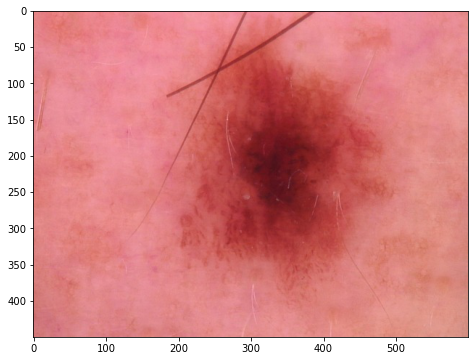

In [56]:
#import image
test_image=plt.imread('ISIC_0024306.jpeg')
test_plot=plt.imshow(test_image)
plt.show()

In [132]:
#resize the image and turn it into grayscale

image = cv2.resize(test_image,(100,100),interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img   

array([[142, 144, 140, ..., 152, 144, 145],
       [144, 142, 139, ..., 152, 148, 148],
       [144, 142, 138, ..., 154, 155, 150],
       ...,
       [132, 132, 131, ..., 153, 149, 146],
       [131, 132, 132, ..., 151, 148, 147],
       [130, 129, 133, ..., 151, 149, 146]], dtype=uint8)

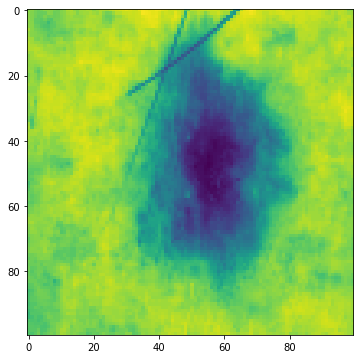

In [59]:
#take a look at the grayscale image
gray_plot=plt.imshow(img)
plt.show()

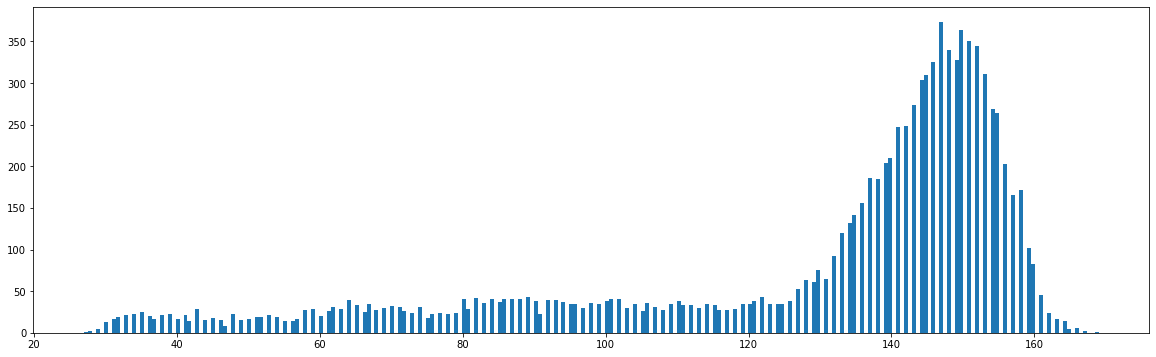

In [134]:
#plot a histogram of the pixel intensity 
plt.hist(img.ravel(), bins=255)
plt.show()

### Experiment with different filtering techniques to separate the background (skin) and the area of interest (AOI -lesion)

Several different techniques were tried including sift, adaptive mean thresholding, Denoising, Lapliacian gausian filter and thresholding.  The best results were achieved with thresholding as presented below on the same image used above:


In [ ]:
#import libraries
import skimage.io
import skimage.color
import skimage.filters

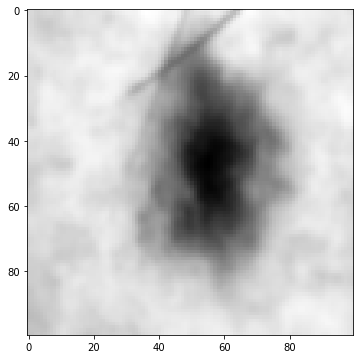

In [135]:
#Convert the image grayscale
gray_img=skimage.color.rgb2gray(image)
#blur the image to denoise
blurred_image=skimage.filters.gaussian(gray_img,sigma=1.0)
#Plot preprocessed image
fig,ax=plt.subplots()
plt.imshow(blurred_image,cmap='gray')
plt.show()

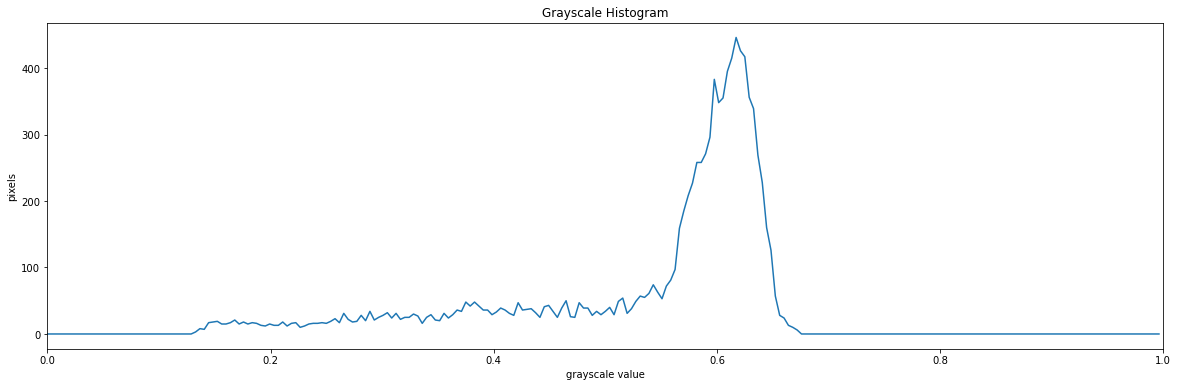

In [136]:
#Create a histogram of the blurred grascale image 
histogram, bin_edges= np.histogram(blurred_image,bins=256,range=(0.0,1.0))
plt.plot(bin_edges[0:-1],histogram)
plt.title("Grayscale Histogram")
plt.xlabel('grayscale value')
plt.ylabel("pixels")
plt.xlim(0,1.0)
plt.show()

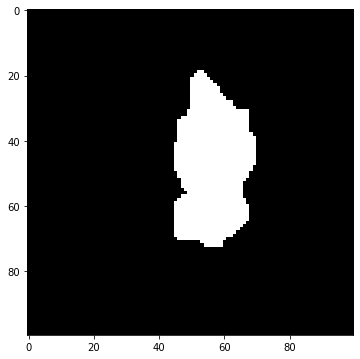

In [137]:
#Create a mask based on the threshold 
t=0.34
binary_mask=blurred_image<t
fig,ax = plt.subplots()
plt.imshow(binary_mask,cmap='gray')
plt.show()

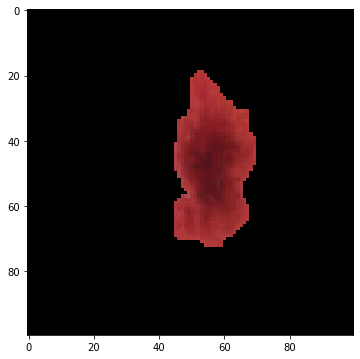

In [138]:
#use the binary mask to select the interesting part of the image 
selection=np.zeros_like(image)
selection[binary_mask]=image[binary_mask]
fig,ax=plt.subplots()
plt.imshow(selection)
plt.show()

## GRAY LEVEL COOCURRANCE MATRIX

In [154]:
# create patches 

PATCH_SIZE = 20

# select some patches from skin areas of the image - on the image above pick up some coordinates corresponding to the black area
skin_locations = [(20,85), (80,50), (15,15), (15,90)]
skin_patches = []
for loc in skin_locations:
    skin_patches.append(img[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from AOI of the image - red area
lesion_locations = [(50,50), (60,60), (60,40), (50,40)]
lesion_patches = []
for loc in lesion_locations:
    lesion_patches.append(img[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
diss_sim = []
corr = []
homogen = []
energy = []
contrast = []
for patch in (skin_patches + lesion_patches):
    glcm = greycomatrix(patch, distances=[2], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    corr.append(greycoprops(glcm, 'correlation')[0, 0])
    homogen.append(greycoprops(glcm, 'homogeneity')[0, 0])
    energy.append(greycoprops(glcm, 'energy')[0, 0])
    contrast.append(greycoprops(glcm, 'contrast')[0, 0])


    

We will add these GLCM properties that we just calculated to a dataframe along with metadata.  For now we will just visualize how the sparation based on the texture works:

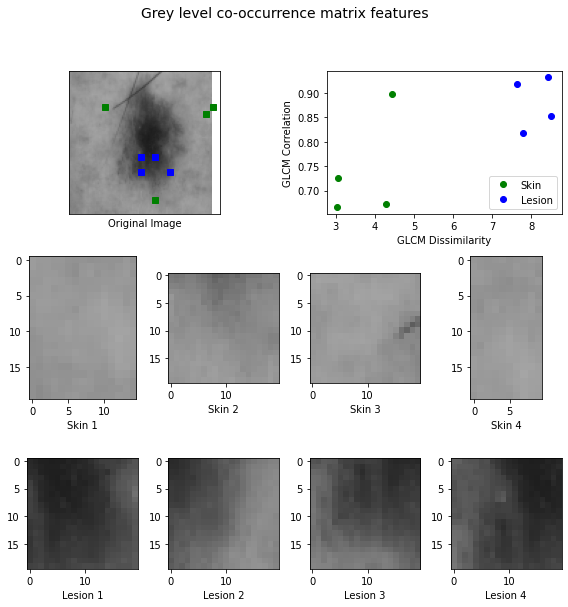

In [155]:
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(img, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in skin_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in lesion_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(diss_sim[:len(skin_patches)], corr[:len(skin_patches)], 'go',
        label='Skin')
ax.plot(diss_sim[len(skin_patches):], corr[len(skin_patches):], 'bo',
        label='Lesion')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(skin_patches):
    ax = fig.add_subplot(3, len(skin_patches), len(skin_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Skin %d' % (i + 1))

for i, patch in enumerate(lesion_patches):
    ax = fig.add_subplot(3, len(lesion_patches), len(lesion_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Lesion %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Based on the correlation vs dissimilarity plot we can see that we already have pretty good separation between skin and the lesion.  To improve, we can tweak the size of the patch, the angle and the distance between pixels compared.  This will be done in a loop when the whole dataset is merged.  Ultimately, the features selected through this process will  be used to run K-means.

References: <br>
1. Marcos A. M. Almeida, and Iury A. X. Santos, Classification Models for Skin Tumor Detection Using Texture Analysis in Medical Images, Journal of Imaging,  Published: 19 June 2020 <br>
2. P. Mohanaiah, P. Sathyanarayana, L. GuruKumar, Image Texture Feature Extraction Using GLCM Approach, International Journal of Scientific and Research Publications, Volume 3, Issue 5, May 2013 <br>
3. S. Bhattiprolu, Python for Microscopists, taken from github and youtube, https://github.com/bnsreenu/python_for_microscopists <br>
4. H. Castillejos-Fernándeza, O. López-Ortegaa, F. Castro-Espinozaa and V. Ponomaryovb, An Intelligent System for the Diagnosis of Skin Cancer on Digital Images taken with Dermoscopy, Acta Polytechnica Hungarica, Vol. 14, No. 3, 2017 <br>
5. J. Hayes, Image Classification -Gray Level Co-Occurrence Matrix (GLCM), http://web.pdx.edu/~jduh/courses/Archive/geog481w07/Students/Hayes_GreyScaleCoOccurrenceMatrix.pdf, last accessed 10/30/21 

Prepared by: Annie Li, Tanja Jancic-Turner, Jose Tellez and Chan Shek (Tom)